In [ ]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from transformers import BertModel, BertTokenizer
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import seaborn as sns
from wordsegment import load, segment

In [ ]:
import re
import emoji
import pandas as pd

# Load data
train_df = pd.read_csv("/kaggle/input/caste-and-migration-hate-speech-detection/train.csv")
dev_df = pd.read_csv("/kaggle/input/caste-and-migration-hate-speech-detection/dev.csv")
df = pd.concat([train_df, dev_df], ignore_index=True)

load()

# -------------------------------
# Text Preprocessing
# -------------------------------

def preprocess_text(text):
    # Extract hashtags
    hashtags = re.findall(r"#\w+", text)

    # Process hashtags (convert to words)
    processed_hashtags = []
    for tag in hashtags:
        tag = tag.lstrip("#")  # Remove #
        words = segment(tag)   # Split compound words
        processed_hashtags.append(" ".join(words))  # Convert to sentence-like format

    # Remove hashtags from main text
    text = re.sub(r"#\w+", "", text)

    # Replace mentions with a placeholder
    text = re.sub(r'@\w+', '<USER>', text)
    
    # Convert emojis to text
    text = emoji.demojize(text, delimiters=(" ", " "))  # Adds spaces around emoji descriptions
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    # Merge cleaned text with processed hashtags
    final_text = text + " " + " ".join(processed_hashtags)

    return final_text

# Apply preprocessing
df['text'] = df['text'].apply(preprocess_text)

# Show sample processed data
df.sample(10)

,id,text,label
0,3268,Indha ariya kandupidippin moolam neenga solla ...,0
1,6239,<USER> unmai therincha nee pesu,0
2,5859,Inga erukka yella dev... boys vadakkan vadakka...,1
3,3519,பீகாரி பிரசாந்த் கிஷோரிடம் கொடுத்த 350 கோடியை ...,1
4,5136,Mumbai Bangalore la 80% percentage outsiders,1
...,...,...,...
6294,5860,This is done by those who want chaos in Tamil ...,0
6295,1441,"வடமாநிலத்தவருக்கு வேலை வாய்ப்பு கொடுப்பதை ,பணி...",0
6296,3253,நம்ம மேல எந்த தப்பும் இல்லை.... ஏன் என்றால் நா...,0
6297,4295,தம்பி உத்திரபிரதேசம் டெல்லி எல்லையில் உள்ள 90%...,1


In [4]:
texts = df['text'].tolist()
labels = df['label'].tolist()
len(texts), len(labels)

(6299, 6299)

In [5]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
model = BertModel.from_pretrained('bert-base-multilingual-cased')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


XLMRobertaForSequenceClassification(
  (roberta): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=

In [6]:
def tokenize_texts(texts):
    return tokenizer(texts, padding=True, truncation=True, return_tensors='pt', max_length=128)

class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels
        self.tokenized_data = tokenize_texts(texts)

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return {
            'input_ids': self.tokenized_data['input_ids'][idx],
            'attention_mask': self.tokenized_data['attention_mask'][idx],
            'label': self.labels[idx]
        }

dataset = TextDataset(texts, labels)
dataloader = DataLoader(dataset, batch_size=16, shuffle=False)

In [7]:
# Extract embeddings
all_embeddings = []
with torch.no_grad():
    for batch in dataloader:
        inputs = {k: v.to(device) for k, v in batch.items() if k in ['input_ids', 'attention_mask']}
        outputs = model(**inputs)
        cls_embeddings = outputs.last_hidden_state[:, 0, :]  # CLS token
        all_embeddings.append(cls_embeddings.cpu())

X = torch.cat(all_embeddings).numpy()
y = np.array(labels)

# Save embeddings
np.save("bert_embeddings.npy", X)

AttributeError: 'SequenceClassifierOutput' object has no attribute 'last_hidden_state'

In [12]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [13]:
models = [
    LogisticRegression(max_iter=1000),
    RandomForestClassifier(n_estimators=100),
    SVC(kernel='rbf'),
    MultinomialNB(),
    KNeighborsClassifier(n_neighbors=5),
    GradientBoostingClassifier(),
    XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    LGBMClassifier()
]
model_names = ['Logistic Regression', 'Random Forest', 'SVM', 'Naive Bayes', 'KNN', 'Gradient Boosting', 'XGBoost', 'LightGBM']

In [14]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

results = {}

for model, name in zip(models, model_names):
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_val_scaled)
    
    acc = accuracy_score(y_val, y_pred)
    f1_macro = f1_score(y_val, y_pred, average='macro')  # <-- Macro F1
    cm = confusion_matrix(y_val, y_pred)
    
    results[name] = {
        'Model': model,
        'Accuracy': acc,
        'Macro F1 Score': f1_macro,
        'Confusion Matrix': cm
    }
    
    print(f"{name} -> Accuracy: {acc:.4f}, Macro F1 Score: {f1_macro:.4f}")
    print("Confusion Matrix:\n", cm)
    print("-" * 50)


Logistic Regression -> Accuracy: 0.6421, Macro F1 Score: 0.5900
Confusion Matrix:
 [[629 169]
 [282 180]]
--------------------------------------------------
Random Forest -> Accuracy: 0.7524, Macro F1 Score: 0.6977
Confusion Matrix:
 [[742  56]
 [256 206]]
--------------------------------------------------
SVM -> Accuracy: 0.6595, Macro F1 Score: 0.5345
Confusion Matrix:
 [[742  56]
 [373  89]]
--------------------------------------------------
Naive Bayes -> Accuracy: 0.6095, Macro F1 Score: 0.5082
Confusion Matrix:
 [[670 128]
 [364  98]]
--------------------------------------------------
KNN -> Accuracy: 0.5857, Macro F1 Score: 0.5587
Confusion Matrix:
 [[525 273]
 [249 213]]
--------------------------------------------------
Gradient Boosting -> Accuracy: 0.6881, Macro F1 Score: 0.6089
Confusion Matrix:
 [[717  81]
 [312 150]]
--------------------------------------------------
XGBoost -> Accuracy: 0.7349, Macro F1 Score: 0.7018
Confusion Matrix:
 [[673 125]
 [209 253]]
------------

In [19]:
voting_clf = VotingClassifier(estimators=[
    ('lr', models[0]), ('rf', models[1]), ('svm', models[2])], voting='hard')
voting_clf.fit(X_train_scaled, y_train)
y_pred_voting = voting_clf.predict(X_val_scaled)
acc_voting = accuracy_score(y_val, y_pred_voting)
f1_voting = f1_score(y_val, y_pred_voting, average='macro')
cm_voting = confusion_matrix(y_val, y_pred_voting)

results['Voting Classifier'] = {
    'Model': voting_clf,
    'Accuracy': acc_voting,
    'Macro F1 Score': f1_voting,
    'Confusion Matrix': cm_voting
}

stacking_clf = StackingClassifier(
    estimators=[('lr', models[0]), ('rf', models[1]), ('svm', models[2])],
    final_estimator=LogisticRegression()
)
stacking_clf.fit(X_train_scaled, y_train)
y_pred_stacking = stacking_clf.predict(X_val_scaled)
acc_stacking = accuracy_score(y_val, y_pred_stacking)
f1_stacking = f1_score(y_val, y_pred_stacking, average='macro')
cm_stacking = confusion_matrix(y_val, y_pred_stacking)

results['Stacking Classifier'] = {
    'Model': stacking_clf,
    'Accuracy': acc_stacking,
    'Macro F1 Score': f1_stacking,
    'Confusion Matrix': cm_stacking
}

In [16]:
import torch.nn.functional as F
from torch.utils.data import TensorDataset

# Convert BERT embeddings and labels to tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

train_dl = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=32, shuffle=True)
val_dl = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=32)

In [21]:
class FeedForwardNN(nn.Module):
    def __init__(self, input_dim):
        super(FeedForwardNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 2)  # binary classification

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        return self.fc3(x)

# Instantiate and train
ff_model = FeedForwardNN(X_train_tensor.shape[1]).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(ff_model.parameters(), lr=1e-4)

# Training loop
epochs = 10
for epoch in range(epochs):
    ff_model.train()
    total_loss = 0
    for xb, yb in train_dl:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        out = ff_model(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs} | Loss: {total_loss:.4f}")

# Evaluation
ff_model.eval()
all_preds = []
with torch.no_grad():
    for xb, _ in val_dl:
        xb = xb.to(device)
        logits = ff_model(xb)
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        all_preds.extend(preds)

ff_acc = accuracy_score(y_val, all_preds)
ff_f1 = f1_score(y_val, all_preds)
ff_cm = confusion_matrix(y_val, all_preds)

results['Feedforward NN'] = {
    'Accuracy': ff_acc,
    'Macro F1 Score': ff_f1,
    'Confusion Matrix': ff_cm
}

Epoch 1/10 | Loss: 105.4425
Epoch 2/10 | Loss: 105.1573
Epoch 3/10 | Loss: 104.8864
Epoch 4/10 | Loss: 104.6867
Epoch 5/10 | Loss: 104.5404
Epoch 6/10 | Loss: 104.7315
Epoch 7/10 | Loss: 104.3301
Epoch 8/10 | Loss: 103.8884
Epoch 9/10 | Loss: 103.8682
Epoch 10/10 | Loss: 103.9504


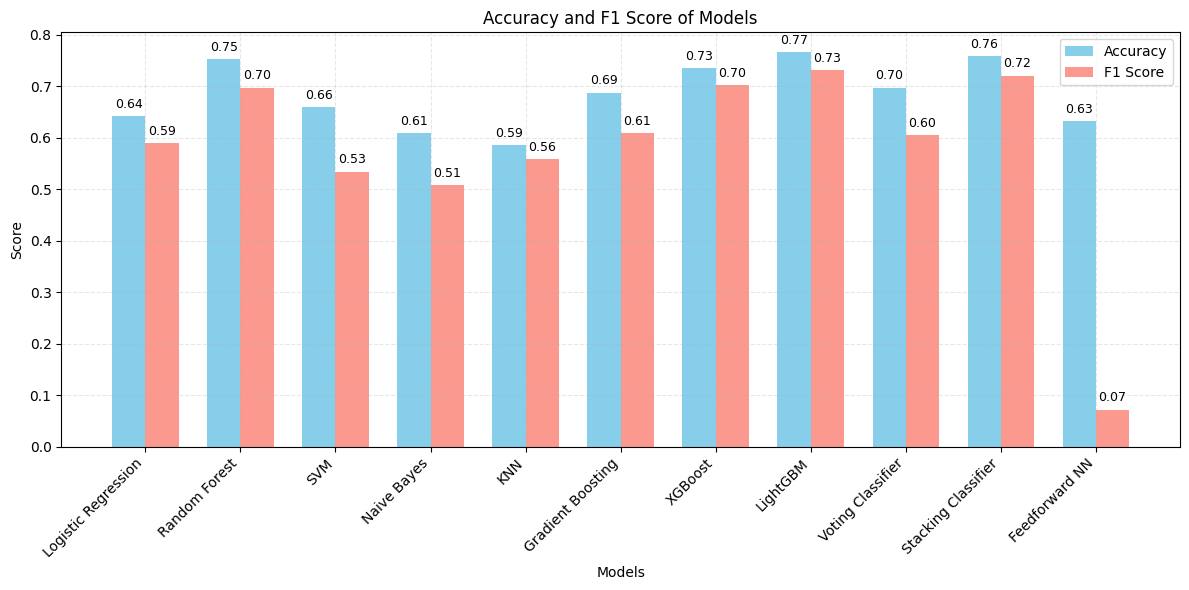


Confusion Matrix for Logistic Regression:
[[629 169]
 [282 180]]


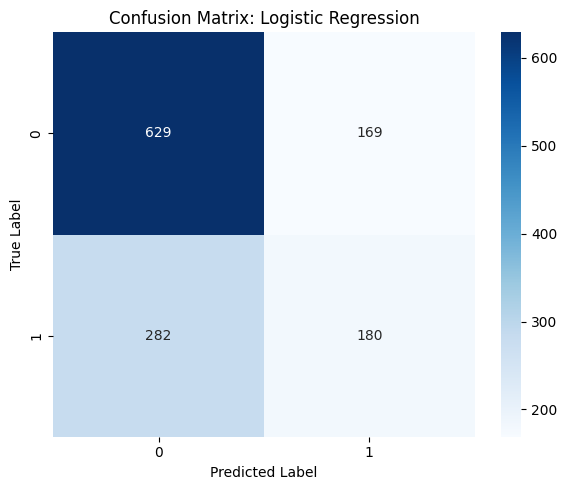


Confusion Matrix for Random Forest:
[[742  56]
 [256 206]]


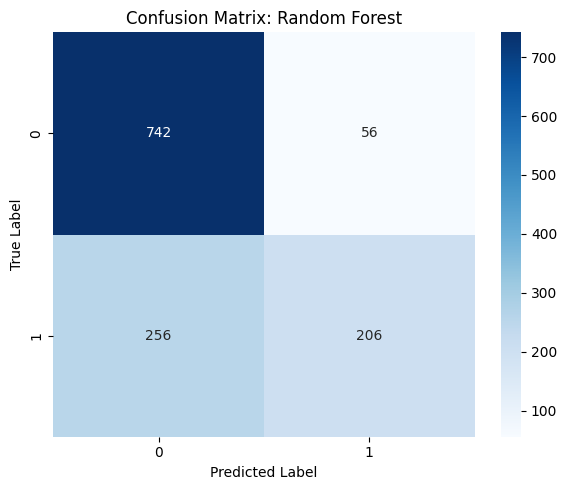


Confusion Matrix for SVM:
[[742  56]
 [373  89]]


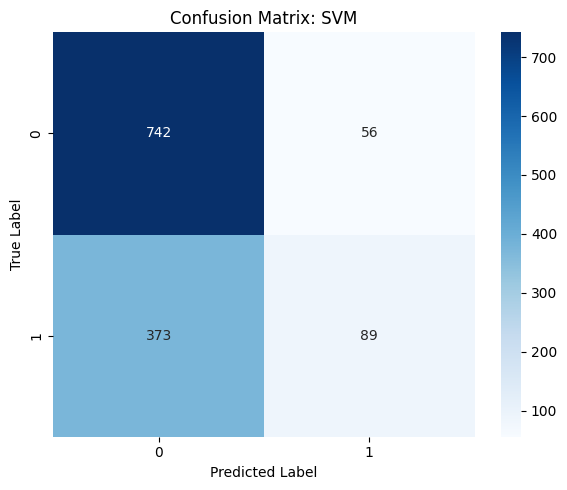


Confusion Matrix for Naive Bayes:
[[670 128]
 [364  98]]


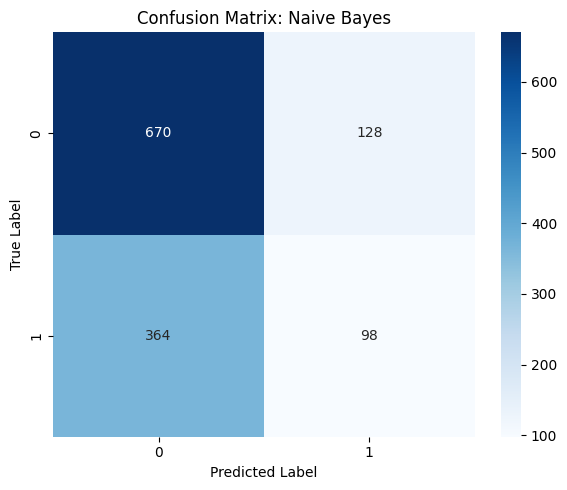


Confusion Matrix for KNN:
[[525 273]
 [249 213]]


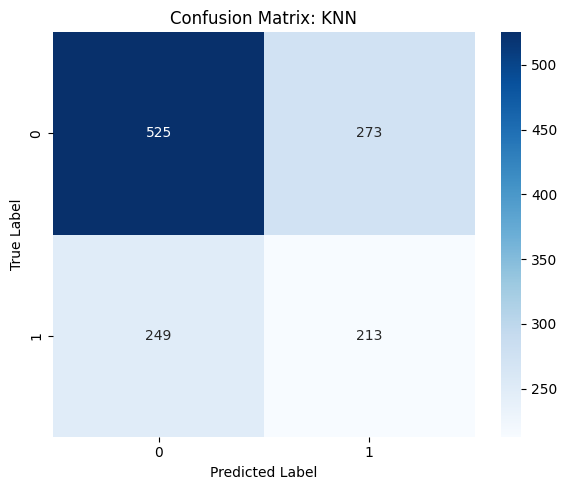


Confusion Matrix for Gradient Boosting:
[[717  81]
 [312 150]]


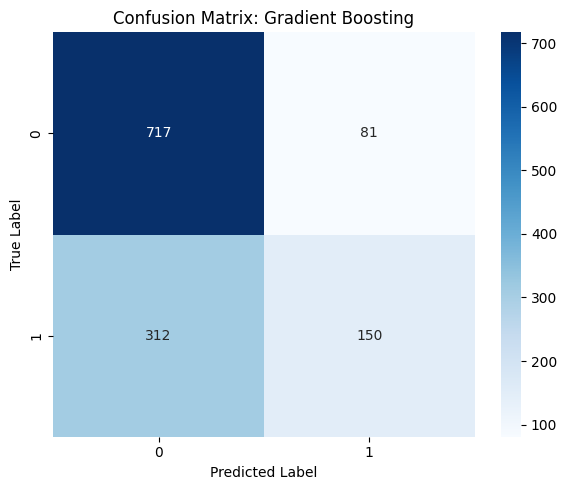


Confusion Matrix for XGBoost:
[[673 125]
 [209 253]]


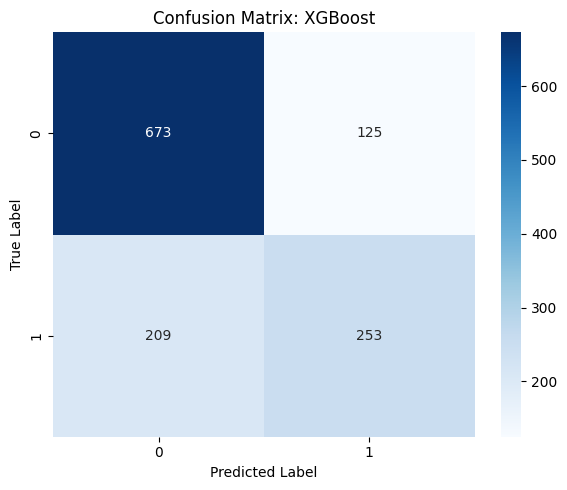


Confusion Matrix for LightGBM:
[[709  89]
 [205 257]]


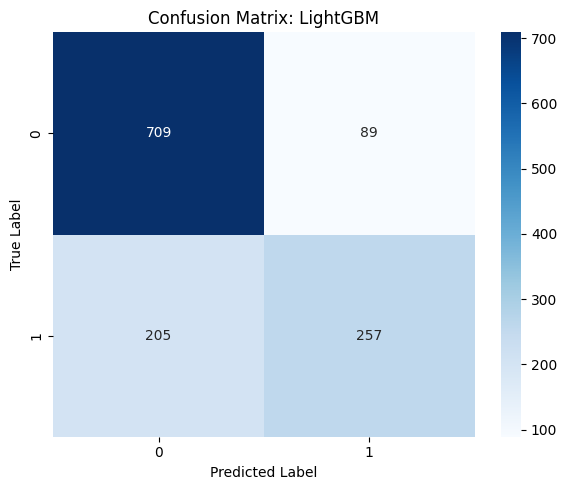


Confusion Matrix for Voting Classifier:
[[745  53]
 [328 134]]


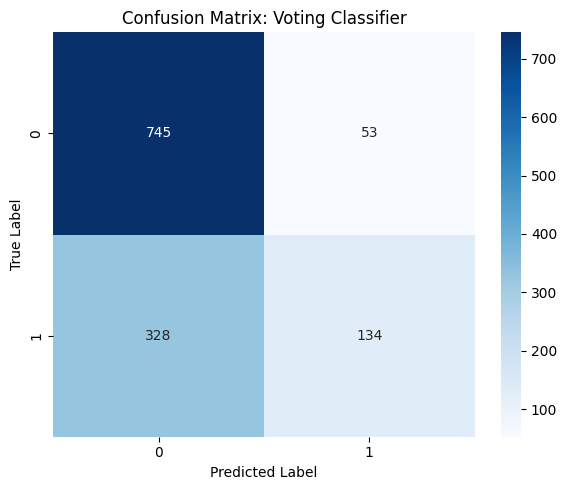


Confusion Matrix for Stacking Classifier:
[[710  88]
 [216 246]]


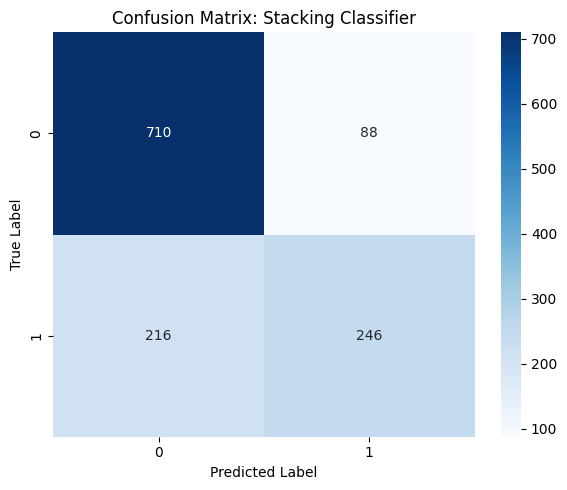


Confusion Matrix for Feedforward NN:
[[779  19]
 [444  18]]


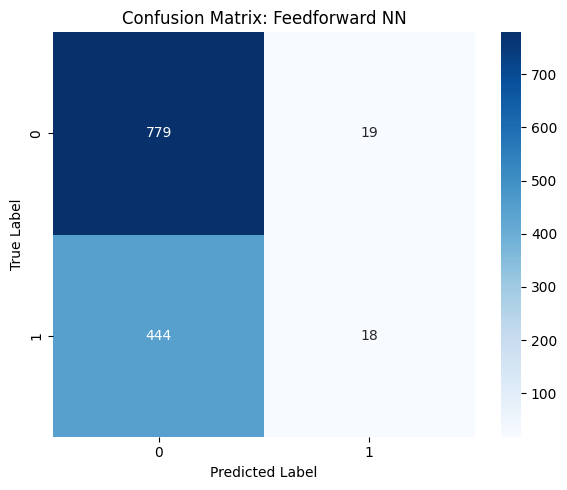

In [23]:
model_labels = list(results.keys())
accuracies = [results[m]['Accuracy'] for m in model_labels]
f1_scores = [results[m]['Macro F1 Score'] for m in model_labels]

fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(model_labels))
bar_width = 0.35

bars1 = ax.bar(x - bar_width/2, accuracies, bar_width, label='Accuracy', color='skyblue')
bars2 = ax.bar(x + bar_width/2, f1_scores, bar_width, label='F1 Score', color='salmon', alpha=0.8)

# Annotate bars with values on top
for bar in bars1:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + 0.01, f'{height:.2f}', ha='center', va='bottom', fontsize=9)

for bar in bars2:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + 0.01, f'{height:.2f}', ha='center', va='bottom', fontsize=9)

ax.set_xlabel('Models')
ax.set_ylabel('Score')
ax.set_title('Accuracy and F1 Score of Models')
ax.set_xticks(x)
ax.set_xticklabels(model_labels, rotation=45, ha='right')
ax.legend()
plt.tight_layout()
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()

# ==========================
# Plot Confusion Matrices
# ==========================
for model_name in model_labels:
    print(f"\nConfusion Matrix for {model_name}:")
    cm = results[model_name]['Confusion Matrix']
    print(cm)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix: {model_name}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.show()

In [ ]:
from collections import Counter
print(Counter(y))